In [1]:
cd C:\Users\nick\Desktop\tfcv\object_detection

C:\Users\nick\Desktop\tfcv\object_detection


In [2]:
import multiprocessing
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from augmentations import photometric_color_distortion

In [3]:
(train_ds, test_ds), info = tfds.load('imdb_wiki_faces', split=['train', 'test'], with_info=True)

In [4]:
info

tfds.core.DatasetInfo(
    name='imdb_wiki_faces',
    version=1.0.0,
    description='Since the publicly available face image datasets are often of small to medium size, rarely exceeding tens of thousands of images, and often without age information we decided to collect a large dataset of celebrities. For this purpose, we took the list of the most popular 100,000 actors as listed on the IMDb website and (automatically) crawled from their profiles date of birth, name, gender and all images related to that person. Additionally we crawled all profile images from pages of people from Wikipedia with the same meta information. We removed the images without timestamp (the date when the photo was taken). Assuming that the images with single faces are likely to show the actor and that the timestamp and date of birth are correct, we were able to assign to each such image the biological (real) age. Of course, we can not vouch for the accuracy of the assigned age information. Besides wrong times

In [5]:
def preprocess(features):
    """Basic Preprocessing and Augmentations to visualized"""
    img = tf.cast(features['image'], dtype=tf.float32)
    img = photometric_color_distortion(img)
    img = img / 255.0
    img = tf.image.resize(img, (224, 224))
    img = tf.image.random_flip_left_right(img)
    
    gender = features['gender']
    age = features['age']
    
    return img, (gender, age)

In [26]:
imgs=[]
labels=[]
for ex in train_ds.take(15):
    name = ex['name'].numpy().decode('utf8')
    img, (gender, age) = preprocess(ex)
    imgs.append(img.numpy())
    labels.append(f"{name}\nGender: {str(gender.numpy())}, Age: {str(age.numpy())}")

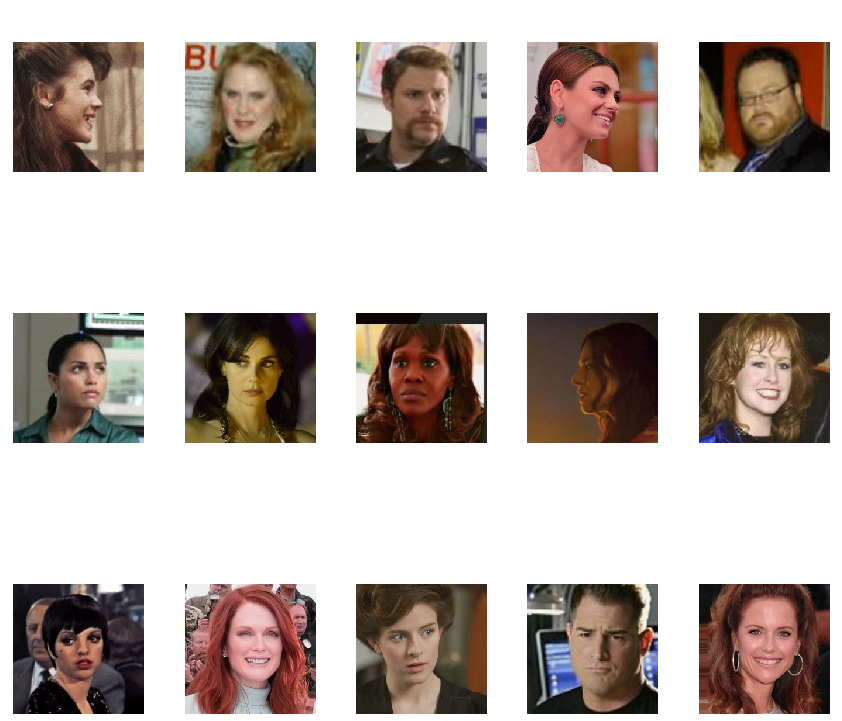

In [28]:
def plot_images(imgs, labels, n=15, fig_size=12, font_size=15):
    """Plot n samples of images"""
    
    fig, axes = plt.subplots(3, int(len(imgs)/3), figsize=(fig_size, fig_size))
    axes = axes.flatten()
    for img, ax, label in zip(imgs, axes, labels):
        ax.imshow(img)
        #ax.set_title(label, color='w', fontsize=font_size)
        ax.set_title(label, color='w', fontsize=font_size)
        ax.axis('off')
                
    plt.tight_layout()
    plt.show()
    
plot_images(imgs, labels)

In [ ]:
cores = multiprocessing.cpu_count()
print(f'# of possible workers: {cores}')

In [ ]:
train_ds = train.map(process, num_parallel_calls=4)

# Shuffle and batch the train_dataset. Use a buffer size of 1024
# for shuffling and a batch size 32 for batching. 
train_ds = train_ds.shuffle(buffer_size=128).batch(32)

# Parallelize the loading by prefetching the train_dataset.
# Set the prefetching buffer size to tf.data.experimental.AUTOTUNE.
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE) 

In [8]:
backbone = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# freeze the backbone layers
backbone.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))

x = backbone(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
age_output = tf.keras.layers.Dense(101, activation='softmax')(x)
gender_output = tf.keras.layers.Dense(2, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=[age_output, gender_output])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss={
                  'age_loss': tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  'gender_loss': tf.keras.losses.CategoricalCrossentropy(from_logits=True)
              }
              metrics=["accuracy"])
model.fit(train_ds, epochs=320)